# Ultra functionalized code
Completely using fast.ai/pytorch libraries and python classes.

In [1]:
from fastai.vision.all import *

/home/gg/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Preparing dataset

In [2]:
full_dataset_dir = untar_data(URLs.MNIST)

In [3]:
image_size=28*28 # np.prod(array(Image.open(Path.ls(full_dataset_dir/'training/3/')[0])).shape)

In [4]:
numbers= [3,7] #range(0,10)

In [5]:
def load_mnist(top_dir='testing'):
    full_dataset=[]
    labels=[]
    for number in numbers:
        path = Path.ls(full_dataset_dir/'{}/{}/'.format(top_dir,number))
        im_tensor = [ tensor(Image.open(p)) for p in path ]
        for i in range(0,len(im_tensor)): # otherwise it would simply be a list of lists
            full_dataset.append(im_tensor[i])
            labels.append(number)
    x_stack = (torch.stack(full_dataset).float()/255).view(-1,image_size)
    y_stack = tensor(labels).unsqueeze(1)
    del full_dataset,labels
    return x_stack, y_stack    

In [6]:
train_x_stack,train_y_stack= load_mnist('training')
test_x_stack,test_y_stack= load_mnist('testing')

In [7]:
train_x_stack.shape, train_y_stack.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [8]:
test_y_stack.shape, test_y_stack.shape

(torch.Size([2038, 1]), torch.Size([2038, 1]))

Assign 1 for 3s and 0 for 7s.

In [9]:
train_y_stack = (train_y_stack == 3) * 1

In [10]:
test_y_stack = (test_y_stack == 3) * 1

Requirement is that a tuple (x,y) is returned when indexed.

# Define Loss function
This function now tells how far the predictions are from targets.

We have 2 targets 0 and 1. If the target is 1, take 1-predictions.
If target is 0, take predictions.
The mean will give the accuracy of the model

In [11]:
def sigmoid(x) : return 1/(1+torch.exp(-x))

def mnist_loss(predictions,targets):
    predictions=sigmoid(predictions)
    return torch.where(targets==1,1-predictions,predictions).mean()

# Define model using pytorch (linear)

In [12]:
linear_model = nn.Linear(image_size,1)

The above initites both these:
```
init_params = lambda size,std=1: (torch.randn(size)*std).requires_grad_()
linear1 = lambda xb: xb@weights + bias
```

In [13]:
weights,bias = linear_model.parameters() # is a parameter object

# Meeting Pytorch requirements for Dataset

In [14]:
train_dset = list(zip(train_x_stack,train_y_stack))
test_dset = list(zip(test_x_stack,test_y_stack))

# Prepare a DataLoader for train and test set

In [15]:
dl = DataLoader(train_dset,batch_size=256) # train in batches for each epoch

In [16]:
test_dl = DataLoader(test_dset,batch_size=256) # train in batches for each epoch

# Calculate gradient function

In [17]:
def calc_grad(x,y,model=linear_model):
    preds = model(x)
    loss = mnist_loss(preds,y)
    loss.backward()

# Optimizer class
The aim is to have a simpler loop to update the params and reset the gradients

In [18]:
class BasicOptim:
    def __init__(self,params,lr):
        self.params = list(params)
        self.lr = lr
    def step(self, *args,**kwargs):
        for p in self.params:
            p.data -= p.grad*self.lr
    def zero_grad(self,*args,**kwargs):
        for p in self.params:
            p.grad.zero_()

This can also be replaced by `opt = SGD(linear_model.parameters(),lr)`. This is a fastai class for SGD.

```
lr = 0.01
opt= BasicOptim(linear_model.parameters(),lr)
```

# Training loop
Is simpler now

In [19]:
lr = 0.1
opt1 = BasicOptim(linear_model.parameters(),lr)
opt2 = SGD(linear_model.parameters(),lr)
def train_epoch(model=linear_model,optimzer=opt1): # default is manual class
    for x, y in dl: # for each batch
        calc_grad(x,y,model)
        optimzer.step()
        optimzer.zero_grad()

# Validation loop

In [20]:
# check for each batch if 3 or 7 and check it with the label
def batch_accuracy(x,y):
    preds=x.sigmoid()
    correct = (preds>0.5) == y
    return correct.float().mean()

In [21]:
def validate_epoch(model=linear_model):
    accs = [batch_accuracy(model(x),y) for x,y in test_dl] # all accuracies for batches
    return round(torch.stack(accs).mean().item(),4)

# Train loop

In [22]:
def train_model(model, optimzer, epochs=10):
    time_start= time.time()
    accur=[]
    for i in range(epochs):
        train_epoch(model,optimzer)
        accur.append(validate_epoch(model))
    print('took {}s'.format(round(time.time()-time_start)))
    return accur

This can be replaced by `Learner.fit` if a `DataLoaders` class is available!. 

This can handle both train and valid set unlike `DataLoader`.


In [23]:
dls = DataLoaders(dl,test_dl)

## Train for 50 epochs

In [24]:
# accur1 = train_model(linear_model,opt1,50) # manual class
# accur2 = train_model(linear_model,opt2,50) # fastai class

In [25]:
# plt.plot(accur1,'r--',label='manual SGD')
# plt.plot(accur2,'b-',label='fastai SGD')
# plt.show()

# Fastai method to do the training bit using `dls`

In [26]:
doc(Learner)

class Learner [source] Learner ( dls , model , loss_func = None , opt_func = Adam , lr = 0.001 , splitter = trainable_params , cbs = None , metrics = None , path = None , model_dir = 'models' , wd = None , wd_bn_bias = False , train_bn = True , moms = (0.95, 0.85, 0.95) ) :: GetAttr 
 
 Group together a model , some dls and a loss_func to handle training 
 Show in docs

In [27]:
learn = Learner(dls, model=linear_model, opt_func=SGD, lr = 0.1, loss_func = mnist_loss, metrics= batch_accuracy)

In [28]:
learn.fit(10)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.228013,0.376483,0.534838,00:00
1,0.124748,0.184984,0.868008,00:00
2,0.084957,0.107945,0.934740,00:00
3,0.066198,0.080549,0.954367,00:00
4,0.056120,0.067275,0.962709,00:00
5,0.050058,0.059478,0.963690,00:00
6,0.046021,0.054327,0.964181,00:00
7,0.043097,0.050650,0.966143,00:00
8,0.040839,0.047876,0.968106,00:00
9,0.039012,0.045698,0.968597,00:00


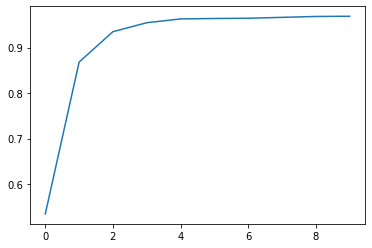

In [29]:
plt.plot(L(learn.recorder.values).itemgot(2))